In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Replace `path` with directory where your `face_images` were downloaded. Available on [Google drive](https://drive.google.com/file/d/1yCYa3IvsvYTkjkl4bvs96pWQfcgOJpxu/view?usp=sharing)

In [2]:
from pathlib import Path
import os, random
location = Path('/home/nonsodono/Documents')
path = location/'face_images'
os.chdir(path)  

### Converting Data to Fastai's `DataBlock` objects.

In [3]:
!pip3 install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

/home/nonsodono/CV_Projects/cv_env/lib/python3.9/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [4]:
#faces = DataBlock(
#    blocks=(ImageBlock, CategoryBlock), 
#    get_items=get_image_files, 
#    splitter=RandomSplitter(valid_pct=0.15, seed=42),
#    get_y=parent_label,
#    item_tfms=Resize(224)
#    )
#dls = faces.dataloaders(path)

In [5]:
tfms = aug_transforms(do_flip = True, flip_vert = False, mult=2.0)
dls= ImageDataLoaders.from_folder(path,train = "train", 
                                   valid_pct=0.15, 
                                   item_tfms=Resize(224), 
                                   batch_tfms=tfms, bs = 32, 
                                   num_workers = 1)

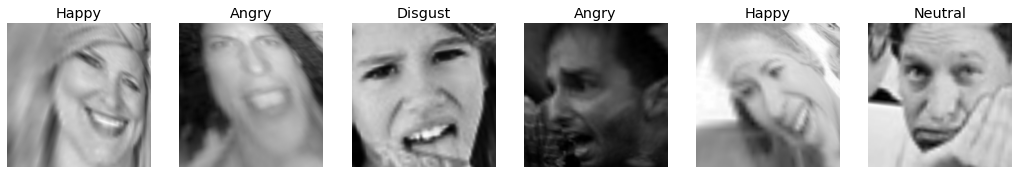

In [6]:
dls.train.show_batch(max_n=6, nrows=1)

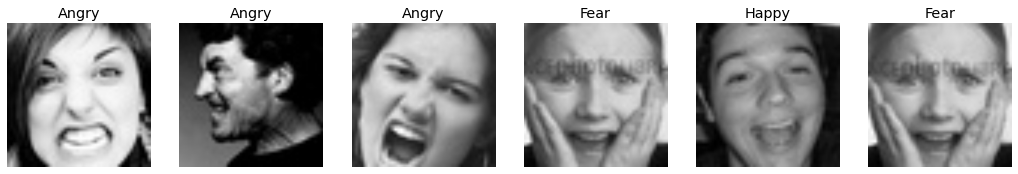

In [7]:
dls.valid.show_batch(max_n=6, nrows=1)

### Data Augmentation

In [8]:
#faces = faces.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2))
#dls = faces.dataloaders(path)
#dls.train.show_batch(max_n=8, nrows=1, unique=True)

### Training the model using Fastai and `vgg19_bn` pretrained model

In [ ]:
model = cnn_learner(dls, vgg16_bn, metrics=accuracy)
model.fine_tune(6)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# model2 = cnn_learner(dls, resnet18, metrics=accuracy)
# model2.fine_tune(11)

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(7,7))

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=2.511886486900039e-05)

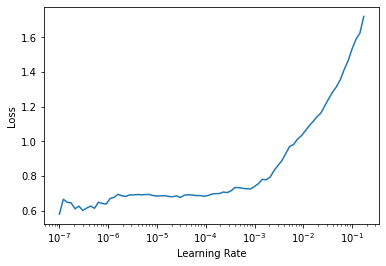

In [33]:
model.lr_find()

In [34]:
model.unfreeze()
model.fine_tune(5, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.772576,0.781219,0.701825,02:47


epoch,train_loss,valid_loss,accuracy,time
0,0.755512,0.782265,0.704380,03:59
1,0.772800,0.760432,0.710584,04:04
2,0.715293,0.780907,0.714963,03:55
3,0.648565,0.786762,0.713504,03:52
4,0.586391,0.780701,0.719343,03:55


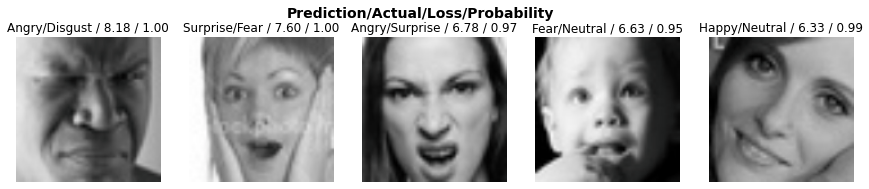

In [35]:
interp.plot_top_losses(5, nrows=1)

### Cleaning the data based on loss data.

In [ ]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), str(path/cat).split('.')[0] + "_fixed_jpg")

### Exporting the model 

In [ ]:
model.export()

In [ ]:
_path = Path()
_path.ls(file_exts='.pkl')

### Make `inferences` from the loaded model

In [ ]:
model_inf = load_learner(path/'export.pkl')

In [ ]:
# Show classes in the model
model_inf.dls.vocab

In [ ]:
model.show_results()

In [ ]:
# Add widgets to upload and classify example images

In [ ]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = model_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your face!'), 
      btn_upload, btn_run, out_pl, lbl_pred])